<div>
<h1>STFT: Inversa</h1> 
</div>

<p>
En este cuaderno, introducimos la DFT inversa y mostramos como recuperar una señal a partir de su STFT bajo condiciones relativamente moderadas en el proceso de enventanado (<i>windowing</i>). Seguimos aqui la Seccion 2.4.2 y la Seccion 8.1.2.1 de <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.
</p> 

## DFT Inversa 


Dado un vector $x\in \mathbb{C}^N$ de longitud $N\in\mathbb{N}$, la [**transformada de Fourier discreta**](./C2_03_DFT-FFT.ipynb) esta definida por el producto matriz&ndash;vector

$$
X = \mathrm{DFT}_N \cdot x
$$

con la matriz $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ dada por 

$$
\mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N)
$$

para $n\in[0:N-1]$ y $k\in[0:N-1]$. La DFT es **invertible** en el sentido de que el vector $x$ puede recuperarse a partir de su vector espectral $X$. La DFT inversa se especifica por un producto matriz&ndash;vector

$$
x = \mathrm{DFT}_N^{-1} \cdot X, 
$$

donde $\mathrm{DFT}_N^{-1}$ denota la **inversa** de la matriz $\mathrm{DFT}_N$ la cual esta dada por 

$$
\mathrm{DFT}_N^{-1}(n, k) = \frac{1}{N}\mathrm{exp}(2 \pi i k n / N)
$$

para $n\in[0:N-1]$ y $k\in[0:N-1]$. En la siguiente celda de codigo, generamos la matriz DFT y su inversa. Ademas, mostramos que ambas matrices son en efecto inversas mutuamente. Con este proposito, medimos la diferencia entre $\mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}$ y la matriz identidad $I_N\in \mathbb{R}^{N\times N}$ asi como tambien entre $\mathrm{DFT}_N^{-1} \cdot\mathrm{DFT}_N$ y la matriz identidad $I_N$.

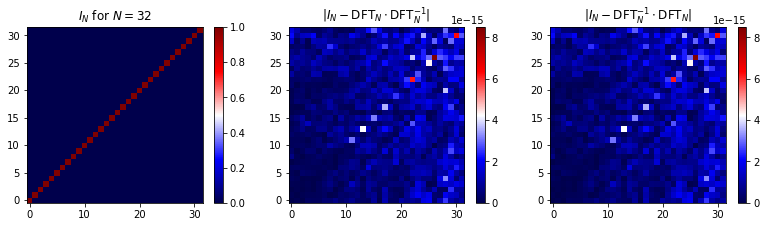

In [1]:
import os
import numpy as np
import scipy.signal
import librosa
from matplotlib import pyplot as plt

import sys
sys.path.append(os.path.join('..','LibUNTREF'))
import C2_Fourier

%matplotlib inline

def generate_matrix_dft_inv(N, K):
    """Generates an IDFT (inverse discete Fourier transfrom) matrix
    Args:
        N: Number of samples
        K: Number of frequency bins
    Returns:
        dft: The IDFT matrix
    """
    dft = np.zeros((K,N),dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k,n] = np.exp(2j*np.pi*k*n/N)/N
    return dft

N = 32
dft_mat = C2_Fourier.generate_matrix_dft(N,N)
dft_mat_inv = generate_matrix_dft_inv(N,N)

I = np.eye(N)
A =  np.dot(dft_mat,dft_mat_inv)
B =  np.dot(dft_mat_inv,dft_mat)

plt.figure(figsize=(11,3))

plt.subplot(1,3,1)
plt.title(r'$I_N$ for $N = %d$'%N)
plt.imshow(I,origin='lower',cmap='seismic',aspect='equal')
plt.colorbar()

plt.subplot(1,3,2)
plt.title(r'$|I_N - \mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}|$')
plt.imshow(np.abs(I-A),origin='lower',cmap='seismic',aspect='equal')
plt.colorbar()

plt.subplot(1,3,3)
plt.title(r'$|I_N - \mathrm{DFT}_N^{-1} \cdot \mathrm{DFT}_N|$')
plt.imshow(np.abs(I-B),origin='lower',cmap='seismic',aspect='equal')
plt.colorbar();

plt.tight_layout()

Recordemos que es posible calcular la DFT en forma eficiente usando el [algoritmo FFT](./C2_03_DFT-FFT.ipynb). Basicamente el mismo algoritmo se puede aplicar para calcular la DFT inversa. En lo que sigue, haremos uso de las implementaciones `numpy.fft.fft` y `numpy.fft.ifft`.

## STFT Inversa 

Ahora, abordamos la cuestion para invertir la discreta [transformada de Fourier a tiempo corto](./C2_05_STFT-Basic.ipynb) (STFT). Como es usual, sea $x:\mathbb{Z}\to\mathbb{R}$ una señal temporal discreta y $\mathcal{X}$ su STFT. Ademas, denotemos por $w:[0:N-1]\to\mathbb{R}$ la funcion ventana discreta a valores reales de longitud $N\in\mathbb{N}$ y denotemos por $H\in\mathbb{N}$ el tamaño de paso (*hop size*). Por razones de notacion, extendemos la funcion $w:\mathbb{Z}\to\mathbb{R}$ usando *zero padding*. Sea $x_n:\mathbb{Z}\to\mathbb{R}$ la señal truncada definida por

\begin{equation}
   x_n(r):=x(r+nH)w(r)
\end{equation}

para $r\in\mathbb{Z}$. Entonces, los coeficientes STFT $\mathcal{X}(n,k)$ para $k\in[0:N-1]$ se obtienen via

$$
  (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top = 
  \mathrm{DFT}_N \cdot (x_n(0),\ldots, x_n(N-1))^\top.
$$

Puesto que $\mathrm{DFT}_N$ es una matriz invertible, podemos reconstruir la señal truncada $x_n$ a partir de la STFT por medio de  

$$
   (x_n(0),\ldots x_n(N-1))^\top
   = \mathrm{DFT}_N^{-1} \cdot (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top
$$

mientras que $x_n(r)=0$ para $r\in\mathbb{Z}\setminus[0,N-1]$. Para obtener las muestras $x(r)$ de la señal original, debemos revertir el proceso de enventanado. Consideremos la superposicion de todas las secciones truncadas de la señal desplazadas de manera adecuada:

$$
   \sum_{n\in\mathbb{Z}} x_n(r-nH)  
   = \sum_{n\in\mathbb{Z}} x(r-nH+nH)w(r-nH)
   = x(r)\sum_{n\in\mathbb{Z}} w(r-nH).   
$$

Por lo tanto, es posible recuperar las muestras $x(r)$ via

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}
$$

siempre y cuando la condicion 

$$
   \sum_{n\in\mathbb{Z}} w(r-nH)\not= 0
$$

se satisfaga para $r\in\mathbb{Z}$. Esta aproximacion global se basa en la tecnica conocida como **overlap&ndash;add**, donde las secciones truncadas son simplemente superpuestas, sumadas y luego normalizadas para compensar el enventanado.

## Partición de la Unidad

No es dificil encontrar funciones ventana junto a tamaños de paso que satisfagan la condicion anterior. Por ejemplo, cuando la funcion ventana $w:[0:N-1]\to\mathbb{R}$ sea estrictamente positiva y el tamaño de paso menor o igual a la longitud de ventana, entonces la suma sobre las ventanas desplazadas en el tiempo sera siempre positiva. A menudo, se elige una funcion ventana y un tamaño de paso tales que la condicion mas restrictiva

$$
   \sum_{n\in\mathbb{Z}} w(r-nH) = 1
$$

para todo $r\in\mathbb{Z}$ se cumpla. En este caso, se dice ademas que las funciones ventana desplazadas en el tiempo definen una **particion de la unidad** del eje de tiempos discreto $\mathbb{Z}$. Por ejemplo, se obtiene una particion de la unidad al emplear la **sinusoide cuadrada** como ventana $w:\mathbb{Z}\to\mathbb{R}$ definida por

\begin{equation}
   w(r):= \left\{ \begin{array}{cl}
                 \sin(\pi r/N)^2 &  \,\mbox{si}\,\,\, r\in[0:N-1],\\
                 0 & \,\mbox{de otro modo} ,
                 \end{array} \right.
\end{equation}

y un tamaño de paso $H=N/2$. La siguiente figura ilustra varias funciones ventana de longitud $N$ y sus versiones desplazadas en el tiempo empleando un tamaño de paso $H$. La suma de las versiones desplazadas se indica por la curva roja.

<img src="../data/C8/FMP_C8_F07_text.png" width="450px" align="middle" alt="FMP_C8_F07_text">

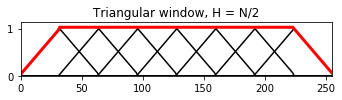

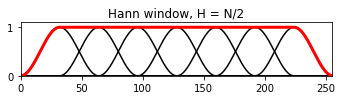

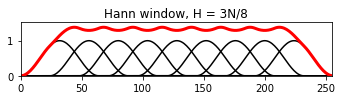

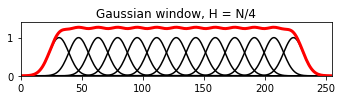

In [2]:
def plot_sum_window(w, H, L, title='', figsize=(5,1.5)):
    N = len(w)
    M = np.floor((L-N)/H).astype(int)+1
    w_sum = np.zeros(L)
    plt.figure(figsize=figsize)
    for m in range(M):
        w_shifted = np.zeros(L)
        w_shifted[m*H:m*H+N] = w
        plt.plot(w_shifted,'k')
        w_sum = w_sum+w_shifted
    plt.plot(w_sum,'r',linewidth=3)
    plt.xlim([0,L-1])
    plt.ylim([0,1.1*np.max(w_sum)])
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return w_sum
     
L = 256
N = 64

H = N//2
w_type = 'triang'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Triangular window, H = N/2');

H = N//2
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = N/2');

H = 3*N//8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = 3N/8');

H = N//4
w = scipy.signal.gaussian(N, std=8)
plot_sum_window(w, H, L, title='Gaussian window, H = N/4');

## Implementacion Basica de la STFT y su Inversa

En la siguiente celda de codigo, proveemos un par de implementaciones para la STFT y su inversa. A continuacion, algunas notas de relevancia practica a tener en cuenta:

* A fin evitar valores imaginarios muy pequeños en la DFT inversa (debido a la aritmetica de punto flotante), resulta beneficioso conservar unicamente la parte real de las ventanas truncadas reconstruidas.
* Luego de aplicar la DFT inversa, debemos compensar el enventanado (*windowing*). En lugar de efectuar este proceso en un nivel *frame-based* (es decir, para cada seccion truncada de manera individual), llevaremos a cabo la compensacion **globalmente** acumulando todas las señales truncadas asi como tambien todas las ventanas desplazadas separadamente. La razon por la cual la compensacion global es posible radica en la **linealidad** de la DFT. Ademas, durante la compensacion, debemos evitar la division por cero.
* En caso que las ventanas desplazadas (para un tamaño de paso dado) formen una particion de la unidad, no requeriremos efectuar compensacion alguna.
* En caso que el procedimiento de relleno [padding](./C2_07_STFT-Padding.ipynb) se aplique en el calculo de la STFT, debemos tener esto en consideracion al calcular la STFT inversa.

<font color="red">En la practica, se emplea a menudo una formula de reconstruccion distinta a la usada en la implementacion siguiente.
</font> 

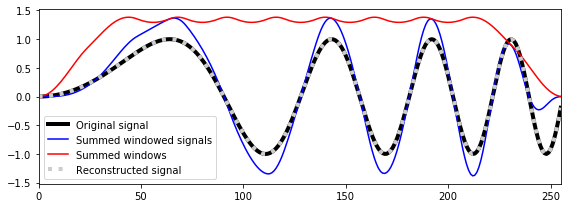

In [4]:
def istft_basic(X, w, H, L):
    """Compute the inverse of the basic discrete short-time Fourier transform (ISTFT)
    Args:
        X: The discrete short-time Fourier transform
        w: Window function
        H: Hop size
        L: Length of time signal
    Returns:
        x: Time signal
    """
    N = len(w)
    M = X.shape[1]
    x_win_sum = np.zeros(L)
    w_sum = np.zeros(L)
    for m in range(M):
        x_win = np.fft.ifft(X[:,m])
        # Avoid imaginary values (due to floating point arithmetic)
        x_win = np.real(x_win)
        x_win_sum[m*H:m*H+N] = x_win_sum[m*H:m*H+N] + x_win
        w_shifted = np.zeros(L)
        w_shifted[m*H:m*H+N] = w
        w_sum = w_sum + w_shifted 
    # Avoid division by zero    
    w_sum[w_sum==0] = np.finfo(np.float32).eps
    x_rec = x_win_sum / w_sum
    return x_rec, x_win_sum, w_sum

L = 256
t = np.arange(L)/L
omega = 4
x = np.sin(2*np.pi*omega*t*t)

N = 64
H = 3*N//8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
X = C2_Fourier.stft_basic(x, w=w, H=H)
x_rec, x_win_sum, w_sum = istft_basic(X, w=w, H=H, L=L)

plt.figure(figsize=(8, 3))
plt.plot(x, color=[0, 0, 0], linewidth=4, label='Original signal')
plt.plot(x_win_sum, 'b', label='Summed windowed signals')
plt.plot(w_sum, 'r', label='Summed windows')
plt.plot(x_rec, color=[0.8, 0.8, 0.8], linestyle=':', linewidth=4, label='Reconstructed signal')
plt.xlim([0,L-1])
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Compensacion Alternativa para el Enventanado

Hemos visto que las muestras $x(r)$ pueden recuperarse a partir de las secciones truncadas de la señal por medio de la formula 

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}
$$

en caso que el denominador sea distinto de cero para $r\in\mathbb{Z}$.
En la practica, cuando se procura reconstruir una señal temporal a partir de una STFT, a menudo debemos tratar con modificaciones (deliberadas o no) en el dominio de la STFT. Este tema sera abordado en el cuaderno sobre Reconstruccion de Señales, correspondiente a la Seccion 8.1.2 de <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

En vista de tales modificaciones, resulta que la siguiente formula brinda un mejor reconstruccion de las muestras $x(r)$:

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} w(r-nH)x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)^2},
$$

donde asumimos nuevamente que el denominador es distinto de cero para $r\in\mathbb{Z}$. En caso que no haya modificaciones en el dominio de la STFT, ambas formulas de reconstruccion generan exactamente las muestras originales. La segunda estrategia se emplea en la funcion `librosa.istft`.

## Implementacion LibROSA 

El paquete Python <a href="https://librosa.github.io/">LibROSA</a> ofrece las funciones `librosa.stft` y `librosa.istft` para el calculo de la STFT y su inversa. A continuacion, probamos ambas funciones. En particular, ponemos en evidencia la importancia de la compensacion por un posible *padding* (esto es, cuando usamos la version *centered* de la STFT). Para el ejemplo usamos el sonido de violin siguiente.

<audio style="width: 320px;" src="../data/C2/FMP_C2_F05c_C4_violin.mp3" type="audio/mpeg" controls="controls"></audio>

=== Centered Case ===
stft: center=True; istft: center=True
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


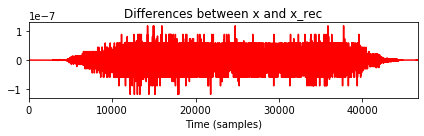

=== Non-Centered Case ===
stft: center=False; istft: center=False
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


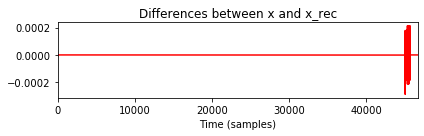

=== Centered vs. Non-Centered Case ===
stft: center=True; istft: center=False
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


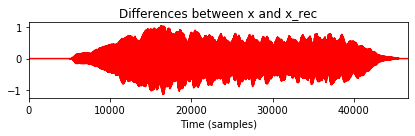

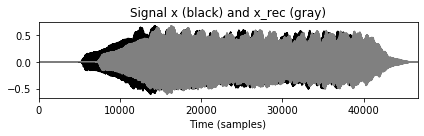

In [6]:
def print_plot(x, x_rec):
    print('Number of samples of x:    ', x.shape[0])
    print('Number of samples of x_rec:', x_rec.shape[0])
    if x.shape[0] == x_rec.shape[0]:
        print('Signals x and x_inv agree:', np.allclose(x, x_rec))
        plt.figure(figsize=(6, 2))
        plt.plot(x-x_rec, color='red')
        plt.xlim([0, x.shape[0]])
        plt.title('Differences between x and x_rec')
        plt.xlabel('Time (samples)');
        plt.tight_layout()
        plt.show()
    else:
        print('Number of samples of x and x_rec does not agree.')

fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F05c_C4_violin.wav')
Fs = 11025
x, Fs = librosa.load(fn_wav, sr=Fs)        
        
N = 4096
H = 2048
L = x.shape[0]

print('=== Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=True, length=L)
print('stft: center=True; istft: center=True')
print_plot(x,x_rec)

print('=== Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=False)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=False; istft: center=False')
print_plot(x,x_rec)

print('=== Centered vs. Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=True; istft: center=False')
print_plot(x,x_rec)

plt.figure(figsize=(6, 2))
plt.plot(x,color='black')
plt.xlim([0,x.shape[0]])
plt.plot(x_rec,color='gray')
plt.title('Signal x (black) and x_rec (gray)')
plt.xlabel('Time (samples)');
plt.tight_layout()
plt.show()

## Implementacion LibUNTREF

Proveemos ademas una implementacion de la FFT, la FFT inversa, la STFT, y la STFT inversa en nuestra libreria `LibUNTREF`. Estas implementaciones incluyen opciones de *padding* y efectuan la visualizacion tipo *centric view* tal como se emplea en los cuadernos FMP (similar a `librosa`). 

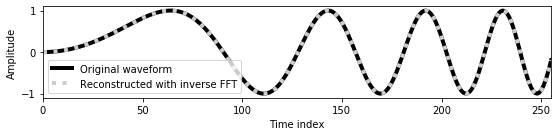

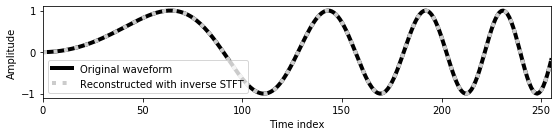

In [2]:
import sys
sys.path.append(os.path.join('..','LibUNTREF'))
import C2_Fourier

L = 256
t = np.arange(L)/L
omega = 4
x = np.sin(2*np.pi*omega*t*t)

X = C2_Fourier.fft(x)
x_rec = np.real(C2_Fourier.ifft(X))
plt.figure(figsize=(8,2))
plt.plot(x,color='k',linewidth=4,label='Original waveform')
plt.plot(x_rec,color=[0.8,0.8,0.8],linestyle=':',linewidth=4,label='Reconstructed with inverse FFT')
plt.xlim([0,L-1])
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

N = 64
H = 3*N//8
w = scipy.signal.get_window('hann',N)
X_stft = C2_Fourier.stft(x,w=w,H=H)
x_stft_rec = C2_Fourier.istft(X_stft,w=w,H=H,L=L)
plt.figure(figsize=(8,2))
plt.plot(x,color='k',linewidth=4,label='Original waveform')
plt.plot(x_stft_rec,color=[0.8,0.8,0.8],linestyle=':',linewidth=4,label='Reconstructed with inverse STFT')
plt.xlim([0,L-1])
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()


In [1]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())